# Análise das Exportações no Comercio Internacional
## Agrupamento de países usando aprendizado não supervisionado
<br>
#### Vinícius Teixeira Mello
#### Belo Horizone,  Junho de 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importação dos dados

O presente trabalho conta com os dados de exportação dos países adquiridos atravez site: https://atlas.media.mit.edu/en/resources/data/. Com as exportações em mãos foi calculado o RCA (Revealed comparative advantage) de cada país em cada uma das 21 categorias do nível mais alto da classificação HS 2007. Essas são as features utilizadas nos modelos implementados nesse trabalho. Por fim uma normalização MinMax foi aplicada nos dados. Todo esse preprocessamento pode ser feito rodado o arquivo *data_preprocessing.py*.

In [2]:
# Importação dos dados já pré-processados
df_hs07 = pd.read_pickle('data_hs07.pkl')

# Dicionário dos códigos dos nomes dos países
count_names = pd.read_csv('dados/country_names.tsv', sep='\t', usecols=[1,2], index_col=0).to_dict()['name']

# Dicionário dos códigos das classes de produtos
class_names = {'01':'Animal Products',
               '02':'Vegetable Products',
               '03':'Animal and Vegetable Bi-Products',
               '04':'Foodstuff',               
               '05':'Mineral Products',
               '06':'Chemical Products',
               '07':'Plastics and Rubbers',
               '08':'Animal Hides',
               '09':'Wood Products',
               '10':'Paper Goods',
               '11':'Textiles',
               '12':'Footwear and Headwear',
               '13':'Stone and Glass',
               '14':'Precious Metals',
               '15':'Metals',
               '16':'Machines',
               '17':'Transportation',               
               '18':'Instruments',
               '19':'Weapons',
               '20':'Miscellaneous',
               '21':'Arts and Antiques',
               '22':'Uspecified'
              }

# Intervalo de anos da análise
years = df_hs07.index.get_level_values(level='year').unique()

## Análise Inicial
### Boxplot

Iniciamos a análise plotando os boxplots referentes as features para cada um dos anos

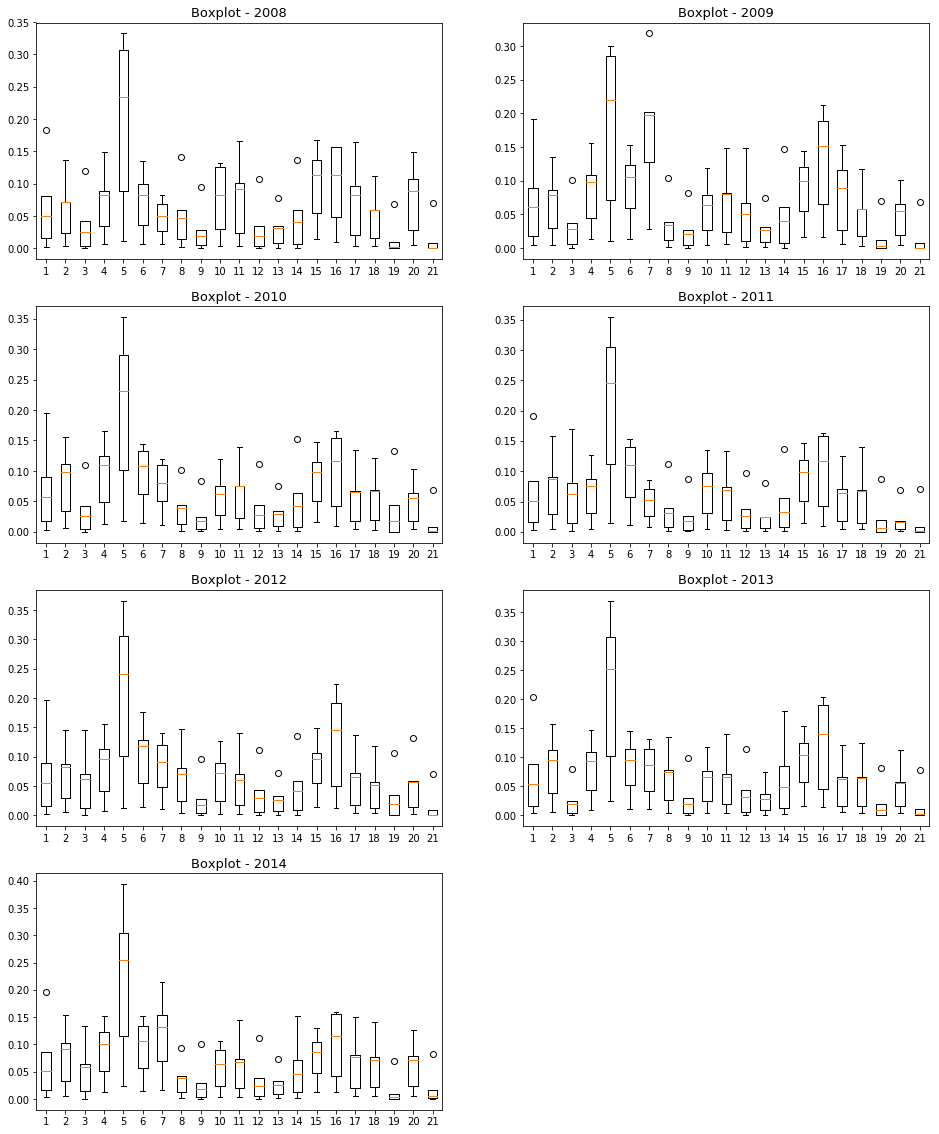

In [3]:
fig, axs = plt.subplots(4, 2, figsize=(16,20))
axs = axs.flatten()
idx = 0
for year in years:
    table = df_hs07.loc[year]['export_rca'].describe().T.drop(['min', 'max', 'count'], axis=1)
    axs[idx].boxplot(table)
    axs[idx].set_title("Boxplot - {:d}".format(year), fontdict={'fontsize':13})
    idx += 1
fig.delaxes(axs[idx])
fig.savefig('figures/analise_inicial/box_plots.png')

### Análise de Componentes Principais

In [4]:
from sklearn.decomposition import PCA

# Porcentagem da variabilidade dos dados explicadas pelas primeiras componentes principais
total = []
for year in years:
    x = df_hs07.loc[year]['export_rca']
    pca = PCA().fit(x)
    cum_sum = [pca.explained_variance_ratio_[0]]
    for v in pca.explained_variance_ratio_[1:]:
        cum_sum.append(v+cum_sum[-1])
    total.append(cum_sum)
    
pd.DataFrame(total, index=range(2008,2015), columns=range(1,22)).iloc[:,:12]

,1,2,3,4,5,6,7,8,9,10,11,12
2008,0.254130,0.352662,0.431051,0.503074,0.569339,0.630207,0.683989,0.731182,0.772137,0.810364,0.843382,0.874474
2009,0.249598,0.376930,0.455583,0.522196,0.581537,0.634436,0.684330,0.733521,0.775671,0.815909,0.850752,0.879627
2010,0.236005,0.349358,0.430308,0.497638,0.558225,0.616191,0.669159,0.718142,0.759622,0.796124,0.828149,0.857514
2011,0.257038,0.366237,0.449738,0.517136,0.573226,0.627431,0.679509,0.727502,0.769943,0.808328,0.843996,0.874898
2012,0.244232,0.357174,0.436297,0.500980,0.564033,0.618018,0.665005,0.710547,0.755332,0.796569,0.830415,0.860023
2013,0.257391,0.377409,0.469667,0.540873,0.599147,0.651963,0.700219,0.746021,0.784998,0.820782,0.853040,0.877330
2014,0.255186,0.372148,0.454579,0.515992,0.575495,0.629810,0.677905,0.724372,0.766722,0.805958,0.841678,0.873930


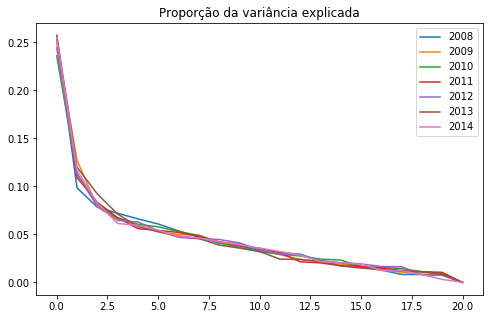

In [5]:
# Porporção da variabilidade explicada por cada uma das componentes principais
plt.figure(figsize=(8,5))
for year in df_hs07.index.get_level_values(level='year').unique():
    x = df_hs07.loc[year]['export_rca']
    pca = PCA().fit(x)
    plt.plot(pca.explained_variance_ratio_ )
plt.legend([y for y in df_hs07.index.get_level_values(level='year').unique()])
plt.title("Proporção da variância explicada", fontsize=12)
plt.savefig("figures/analise_inicial/PCA_var.png")


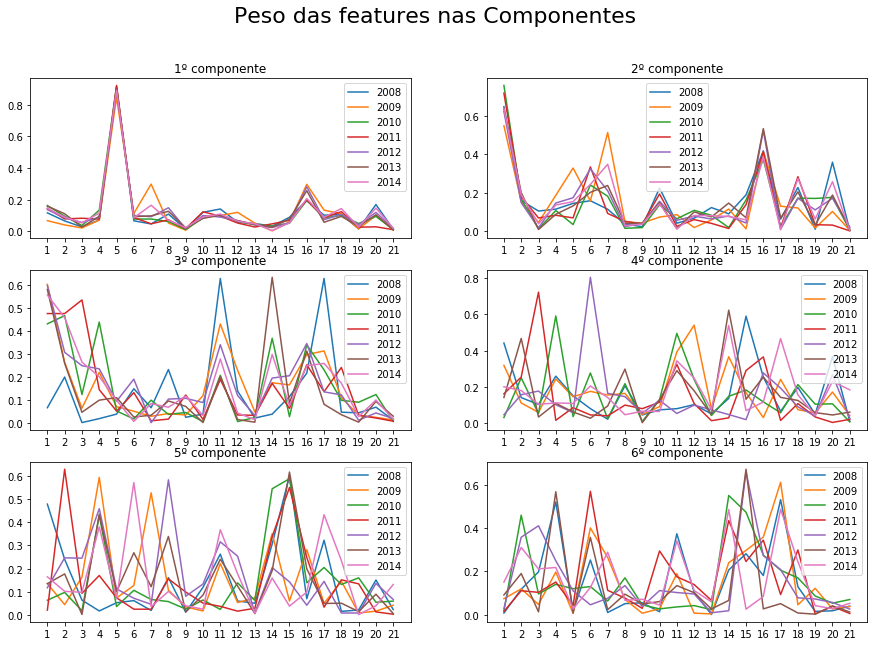

In [6]:
# Pesos das features na primeiras componentes principais 
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
plt.suptitle('Peso das features nas Componentes', fontsize=22)
axs = axs.flatten()
idx = 0
for i in range(6):
    for year in df_hs07.index.get_level_values(level='year').unique():
        x = df_hs07.loc[year]['export_rca']
        pca = PCA().fit(x)
        axs[idx].plot(range(1,22),abs(pca.components_[i]))
        axs[idx].set_xticks(range(1,22))
    axs[idx].legend([y for y in df_hs07.index.get_level_values(level='year').unique()])
    axs[idx].set_title("{:d}º componente".format(i+1), fontsize=12)
    idx += 1
plt.savefig("figures/analise_inicial/PCA_explica.png")

## t-SNE 

### HS07

In [7]:
from sklearn.manifold import TSNE

# Mapeamento dos dados para um duas dimensões usando t-SNE
exp_mapping_hs07 = TSNE(2, method='exact', random_state=23).fit_transform(df_hs07['export_rca'])
exp_mapping_hs07 = pd.DataFrame(exp_mapping_hs07, index=df_hs07.index)

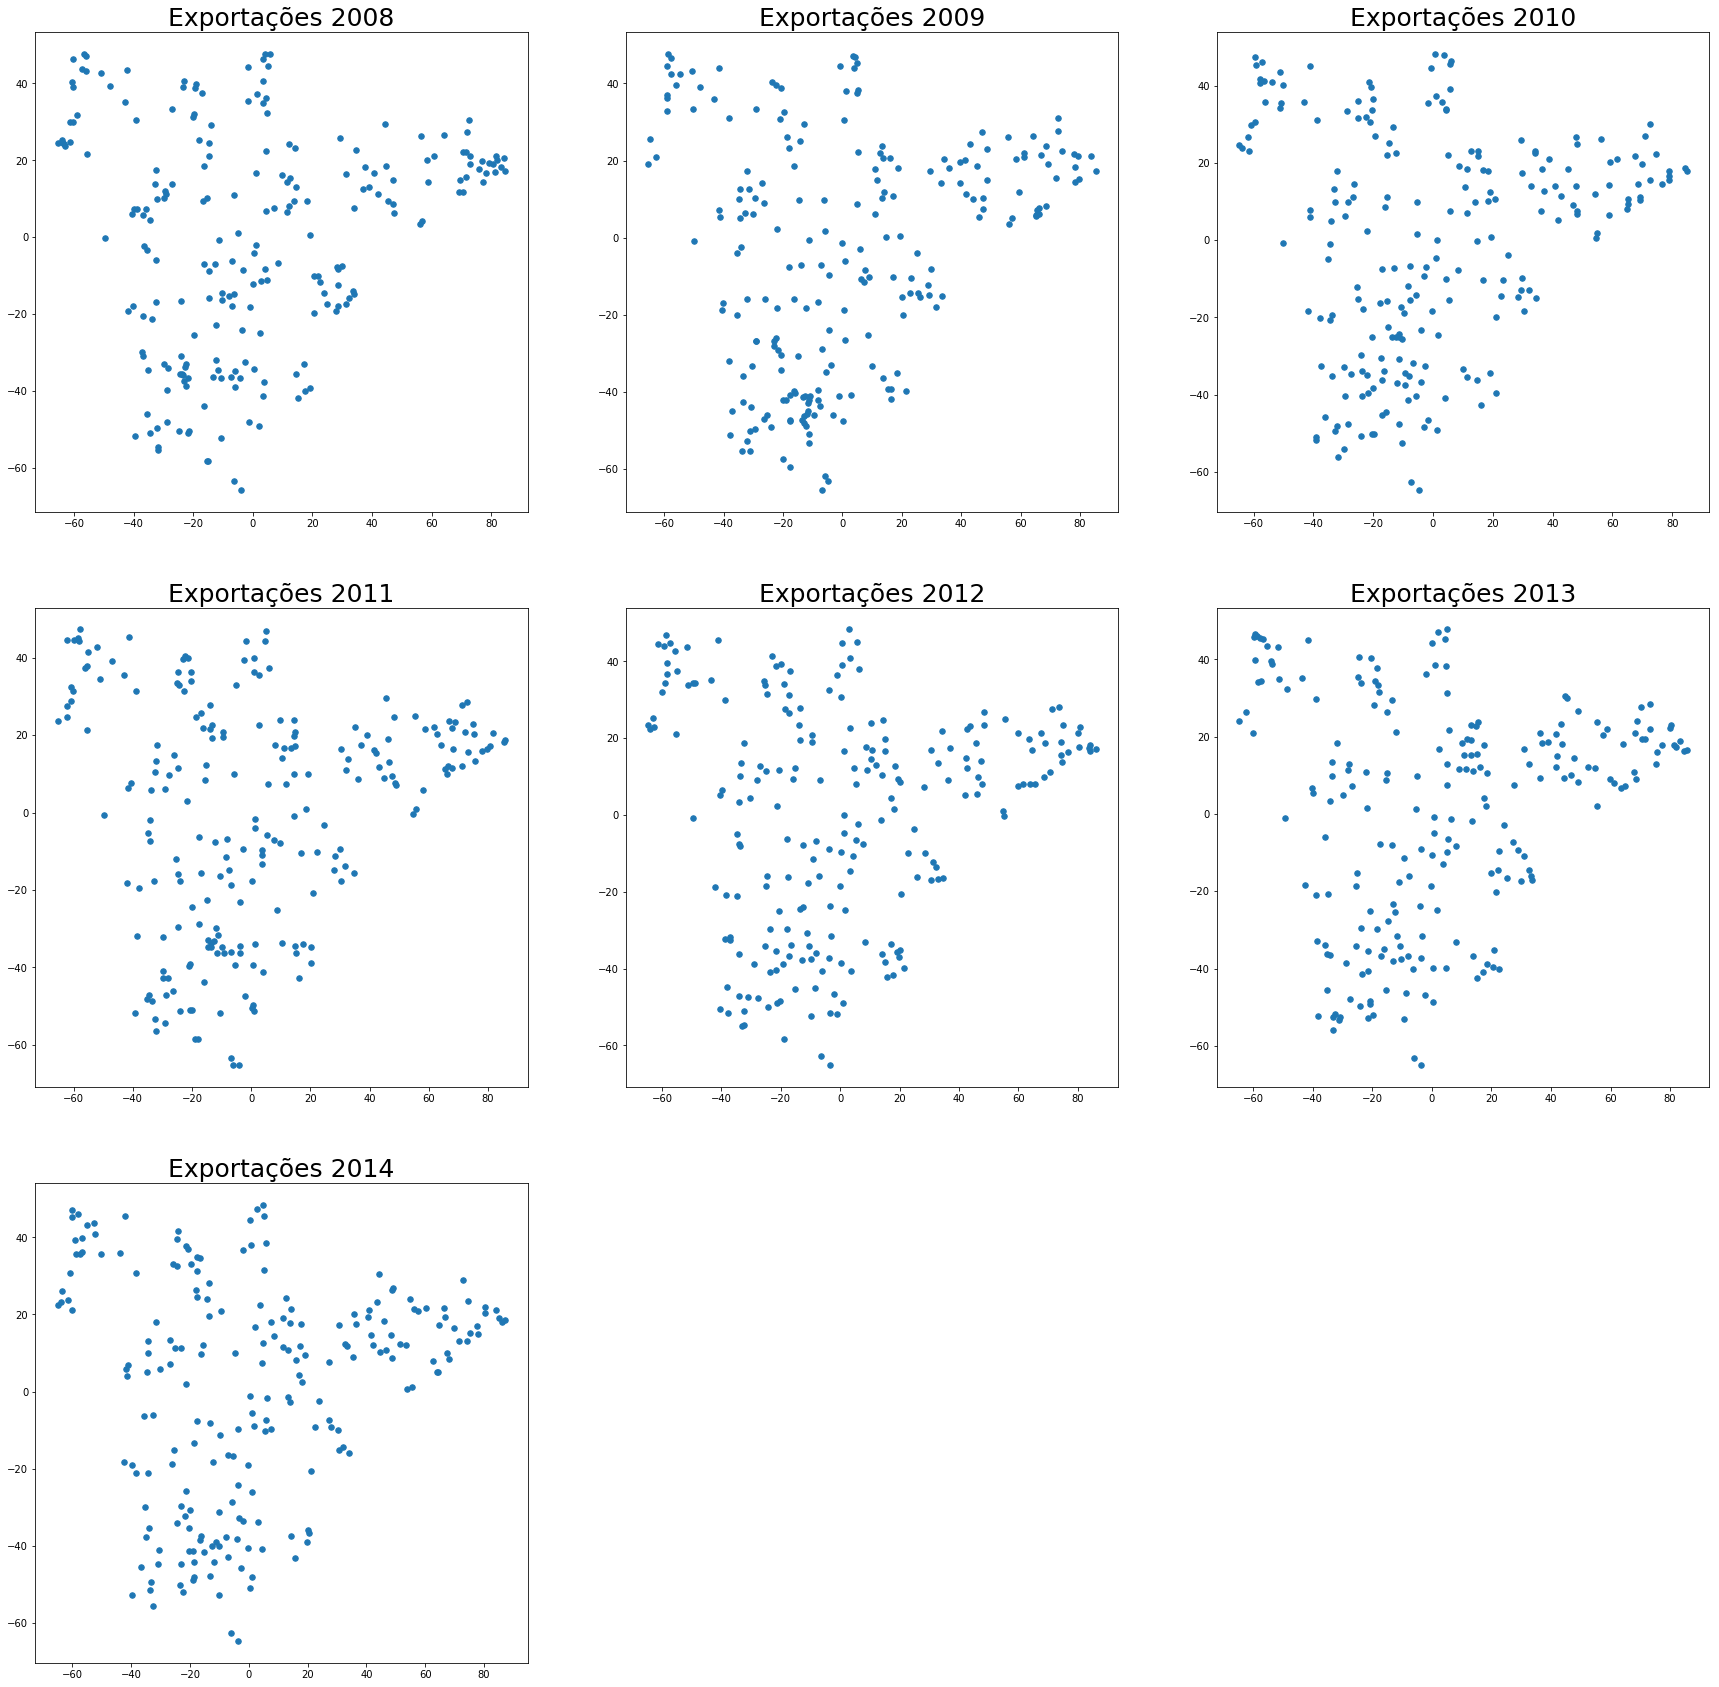

In [8]:
# Mapeamento t-SNE 
fig, axs = plt.subplots(3, 3, figsize=(30, 30))
axs = axs.flatten()
idx = 0
for year in exp_mapping_hs07.index.get_level_values(level='year').unique():
    x = exp_mapping_hs07.loc[year].values
    axs[idx].scatter(x[:,0],x[:,1], s=30)
    axs[idx].set_title("Exportações {:d}".format(year), fontdict={'fontsize':25})
    idx += 1
plt.delaxes(axs[idx])
plt.delaxes(axs[idx+1])
plt.savefig("figures/tsne/tsne_exp_hs07.png")

## Agrupamente Hierárquico

In [9]:
from clustering import hierarchical_clustering, k_means

In [11]:
# Testando diferentes números de clusters para Exportação
years = df_hs07['export_rca'].index.get_level_values(level='year').unique()
results = pd.DataFrame(columns=years)
for k in range(2,20):
    s, _ = hierarchical_clustering(df_hs07['export_rca'], exp_mapping_hs07, k, False, 'exp')
    results = results.append(pd.Series(s, index=years, name=k))

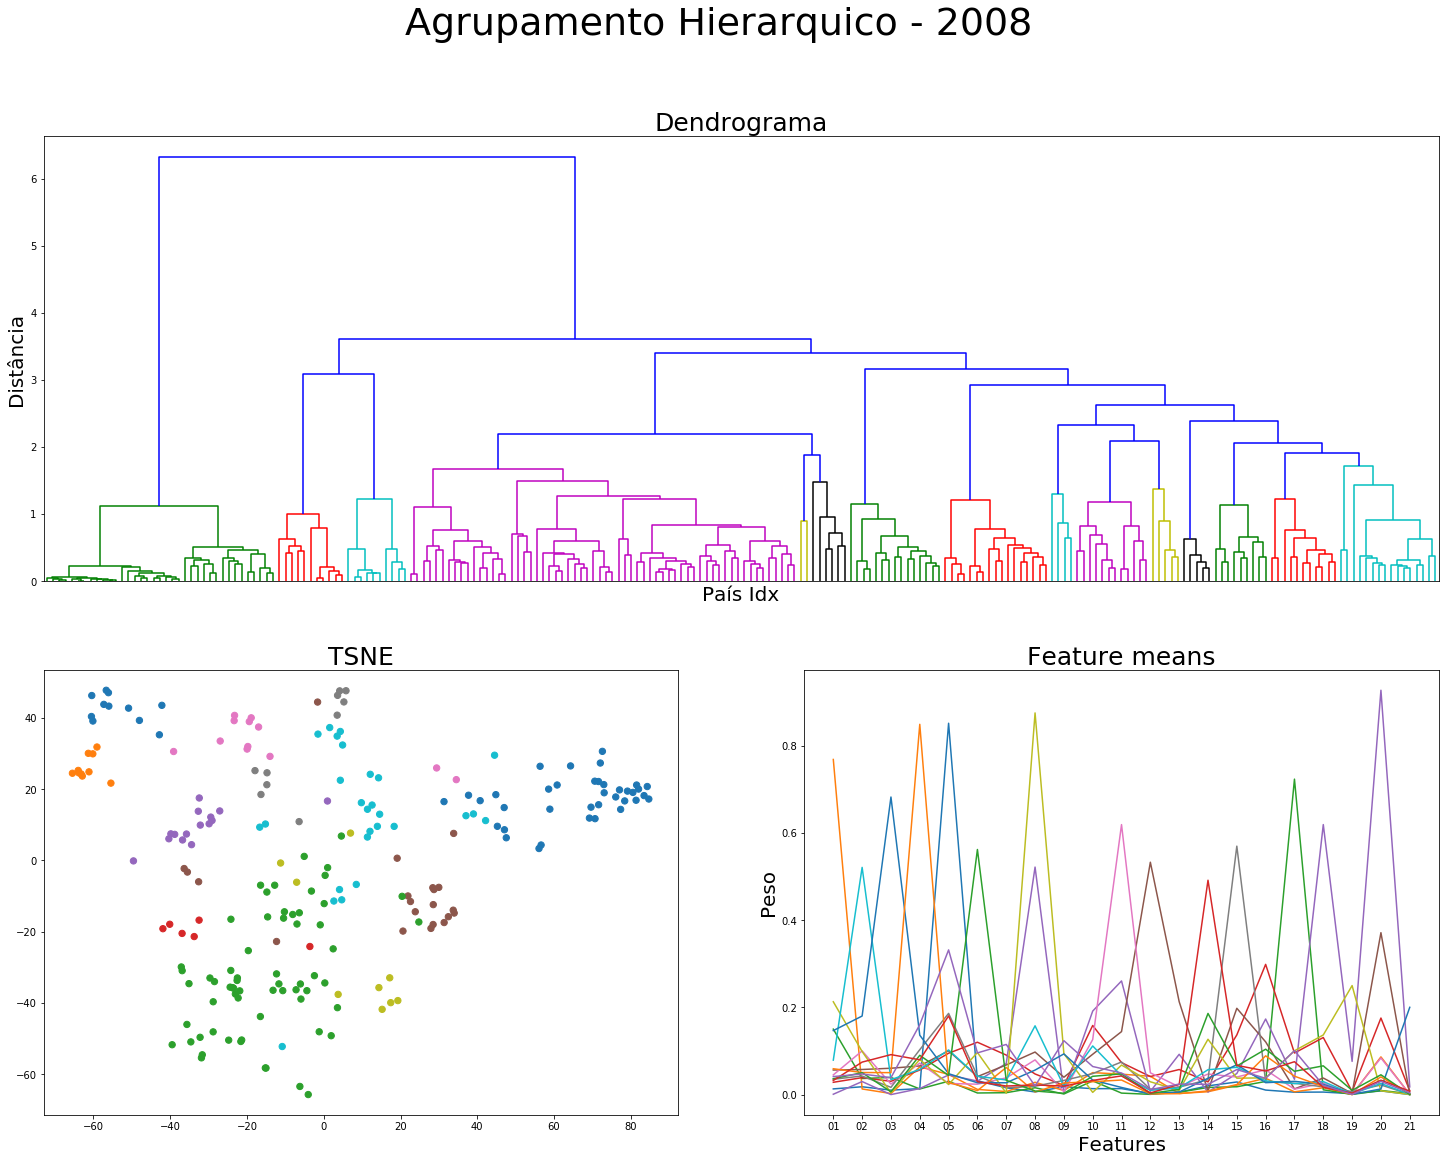

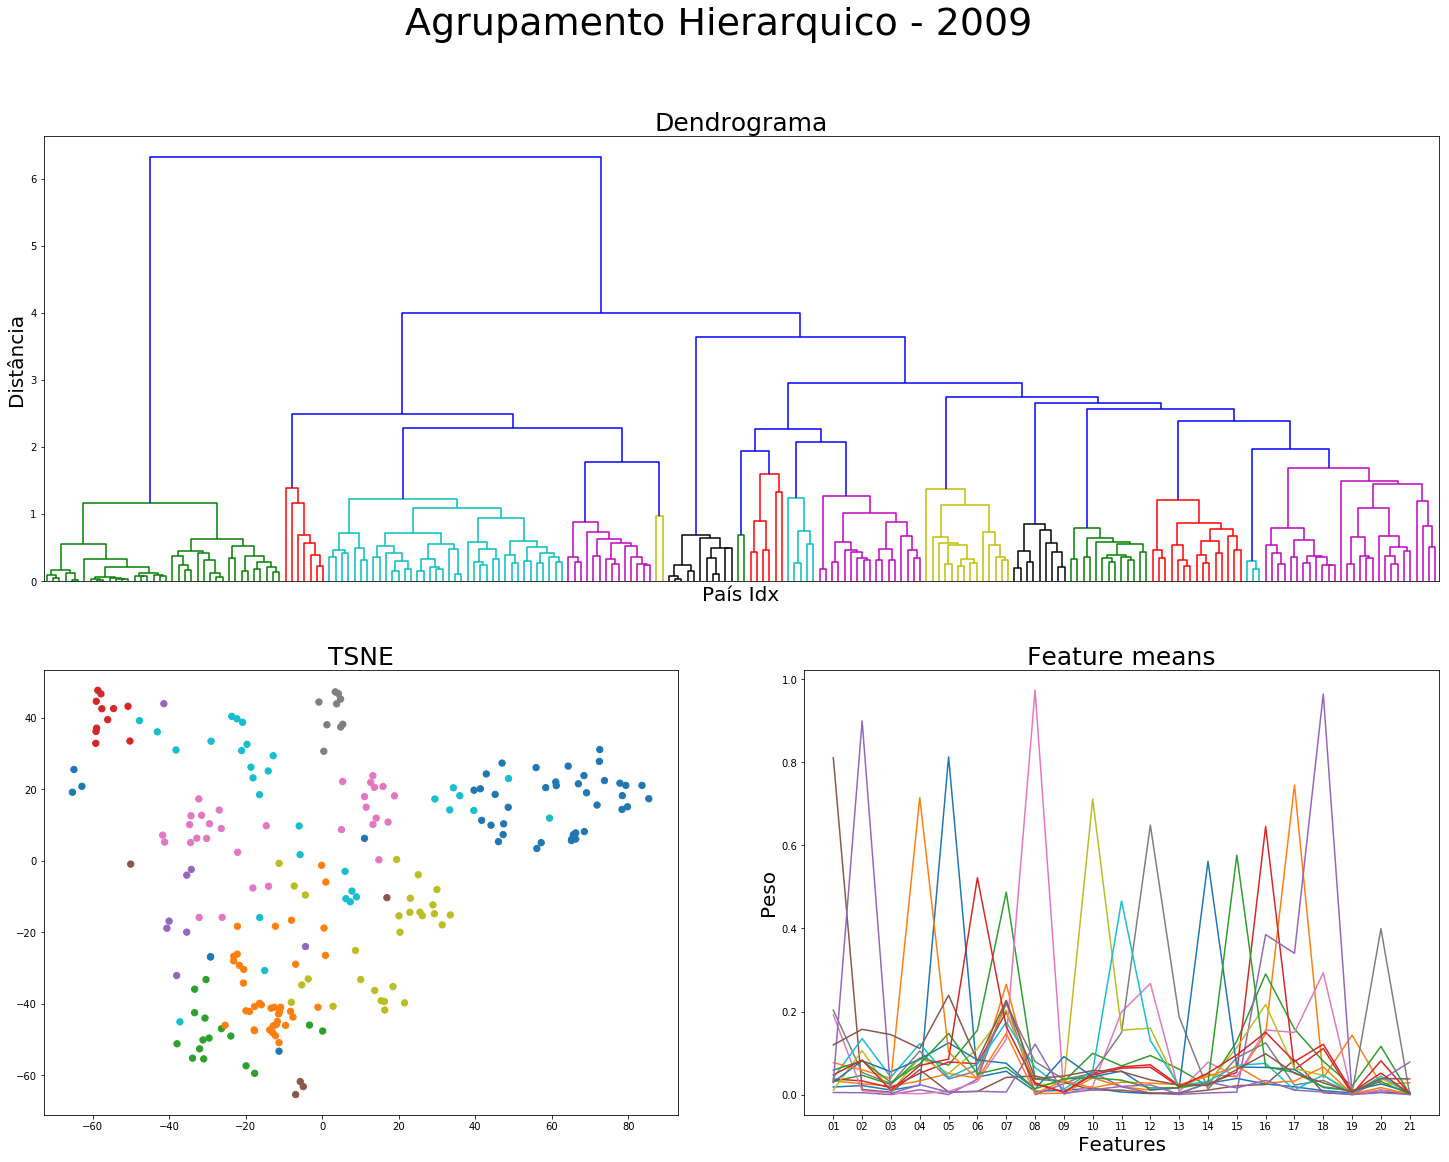

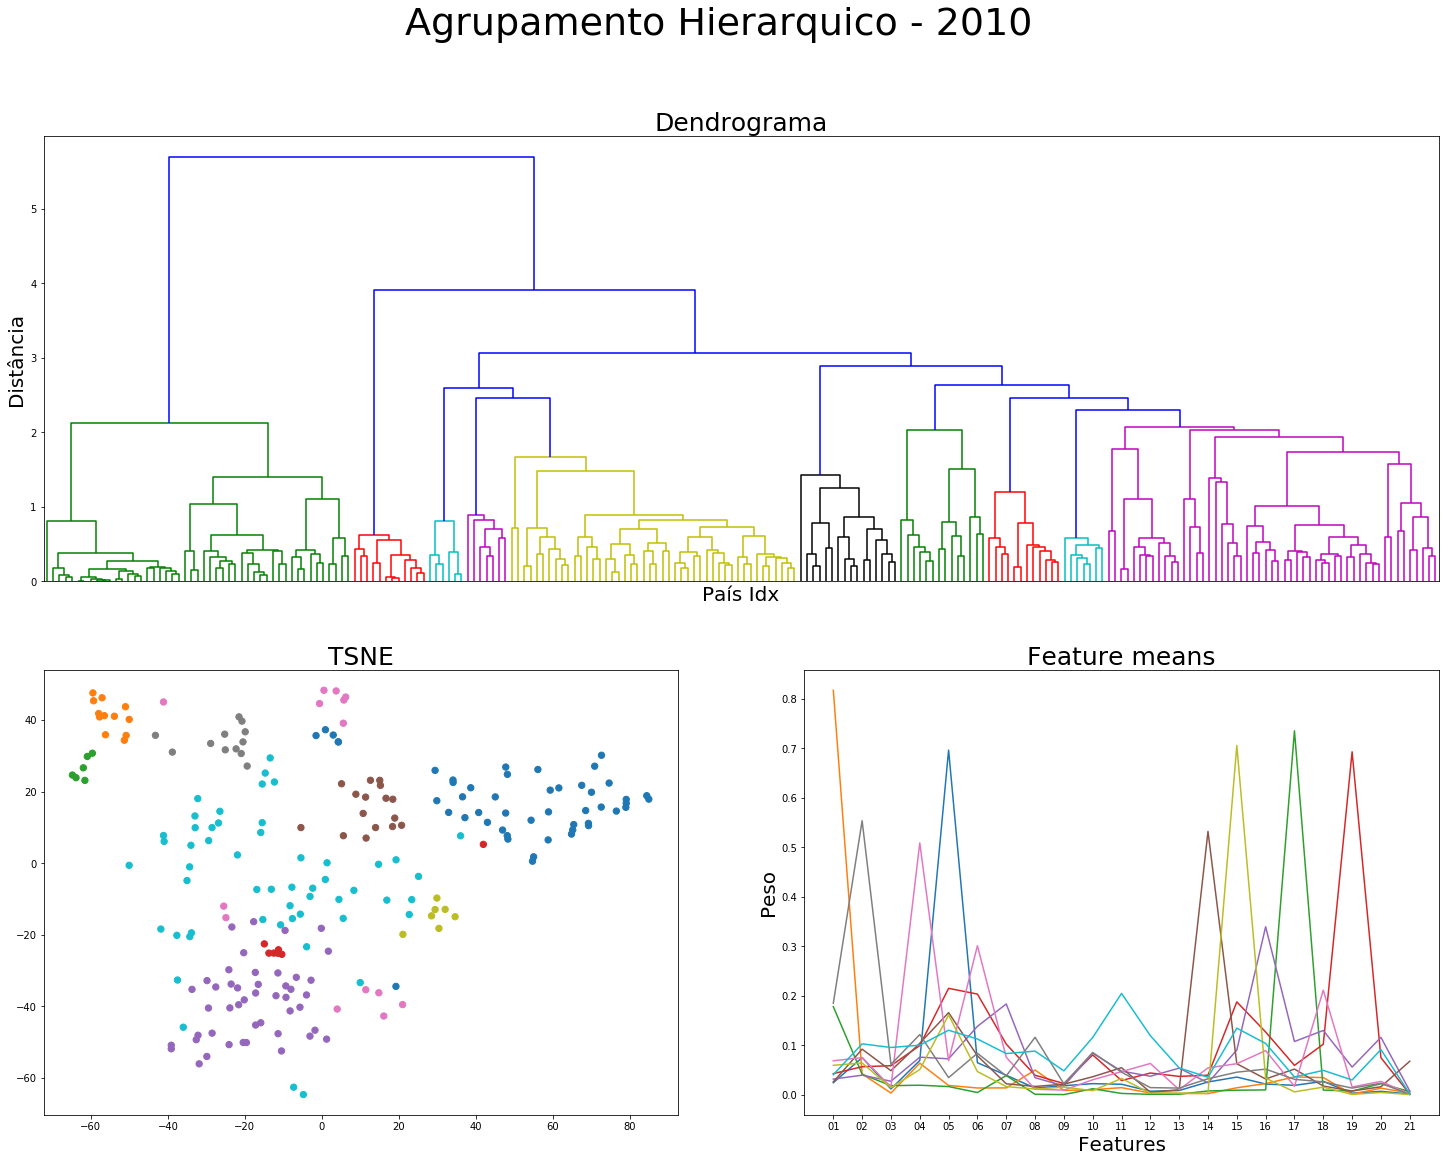

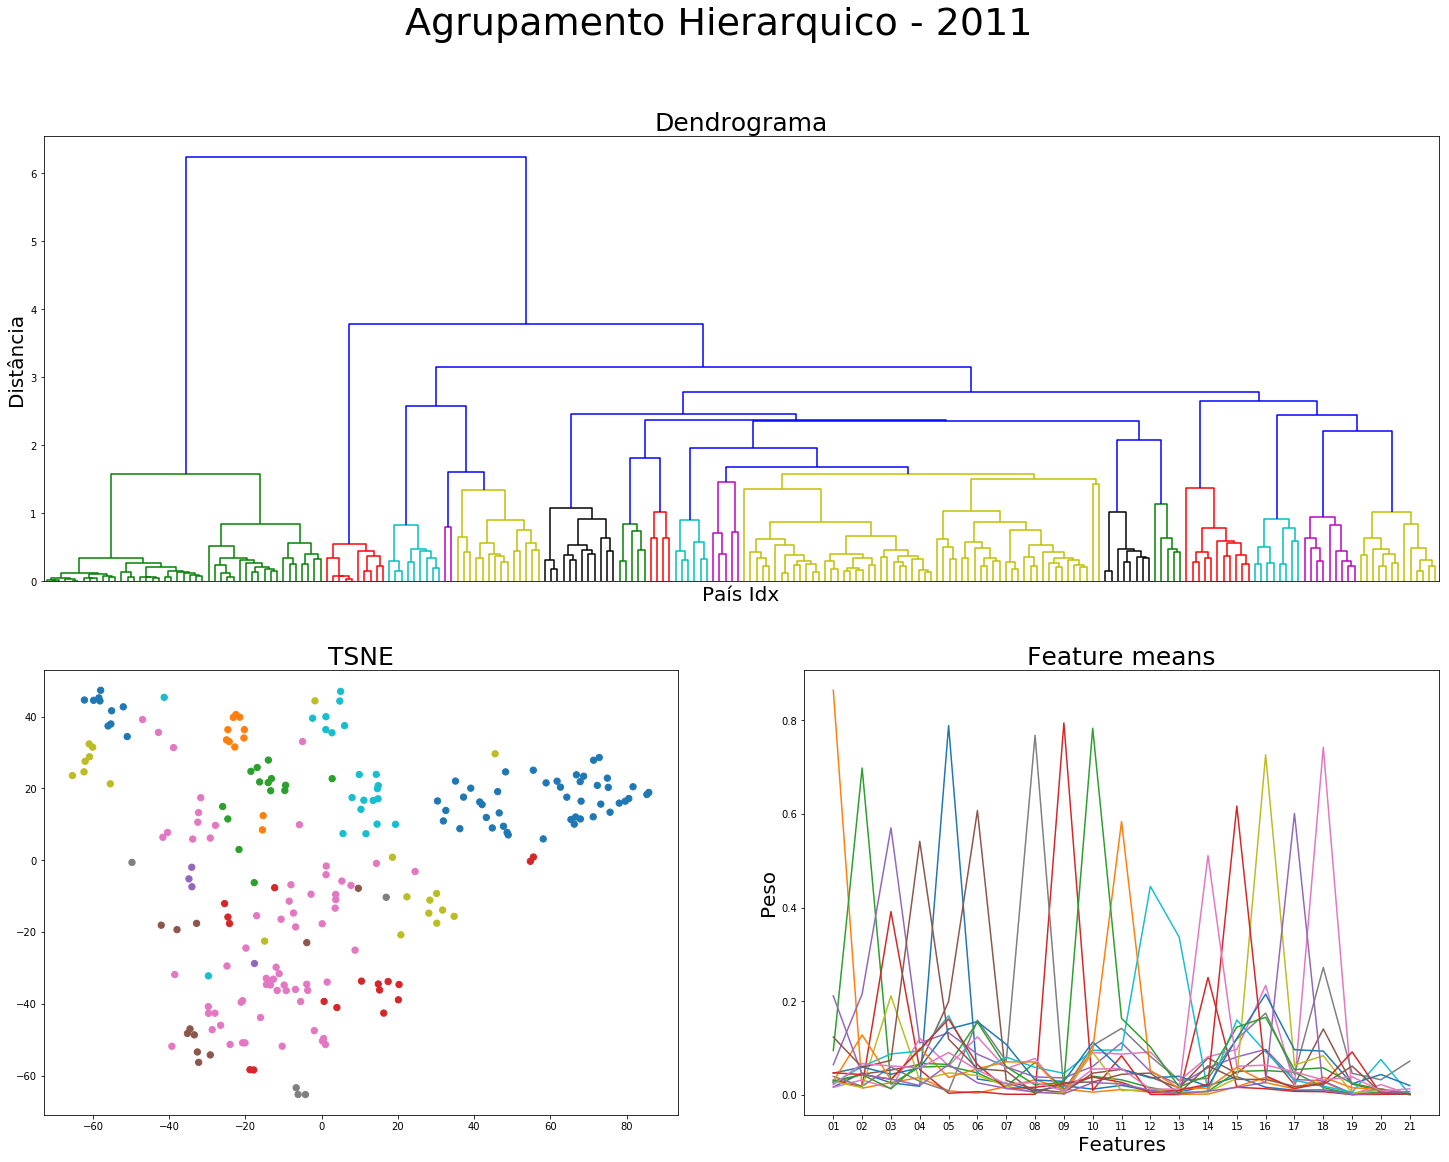

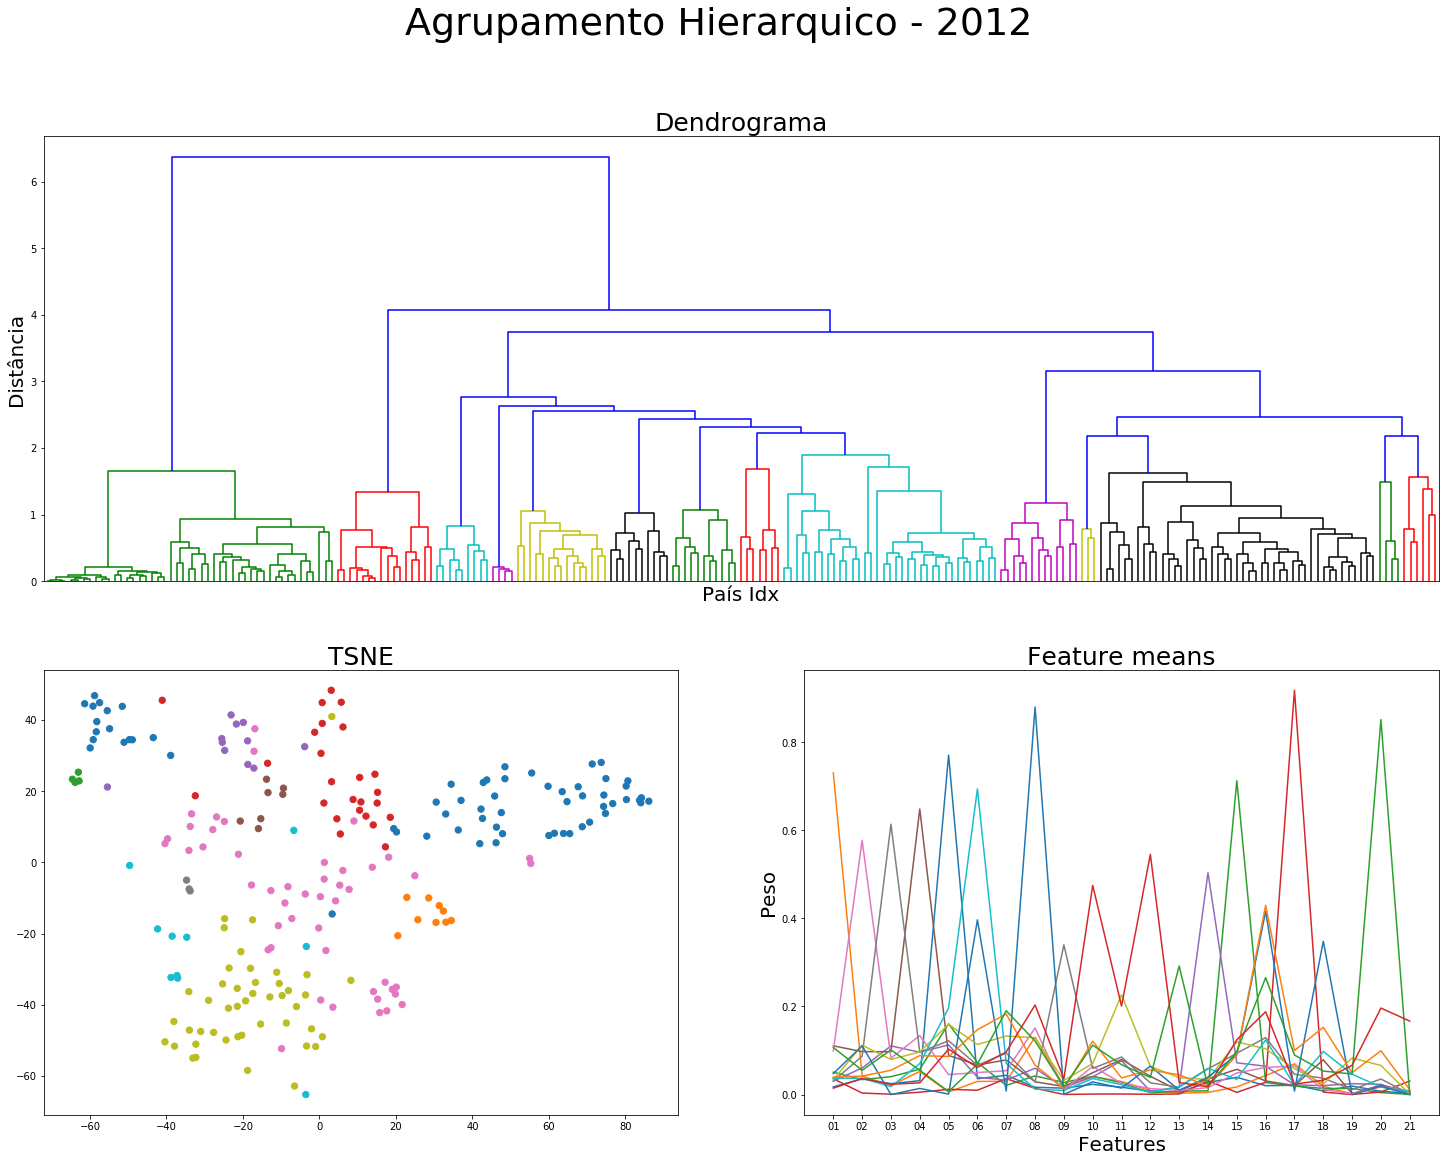

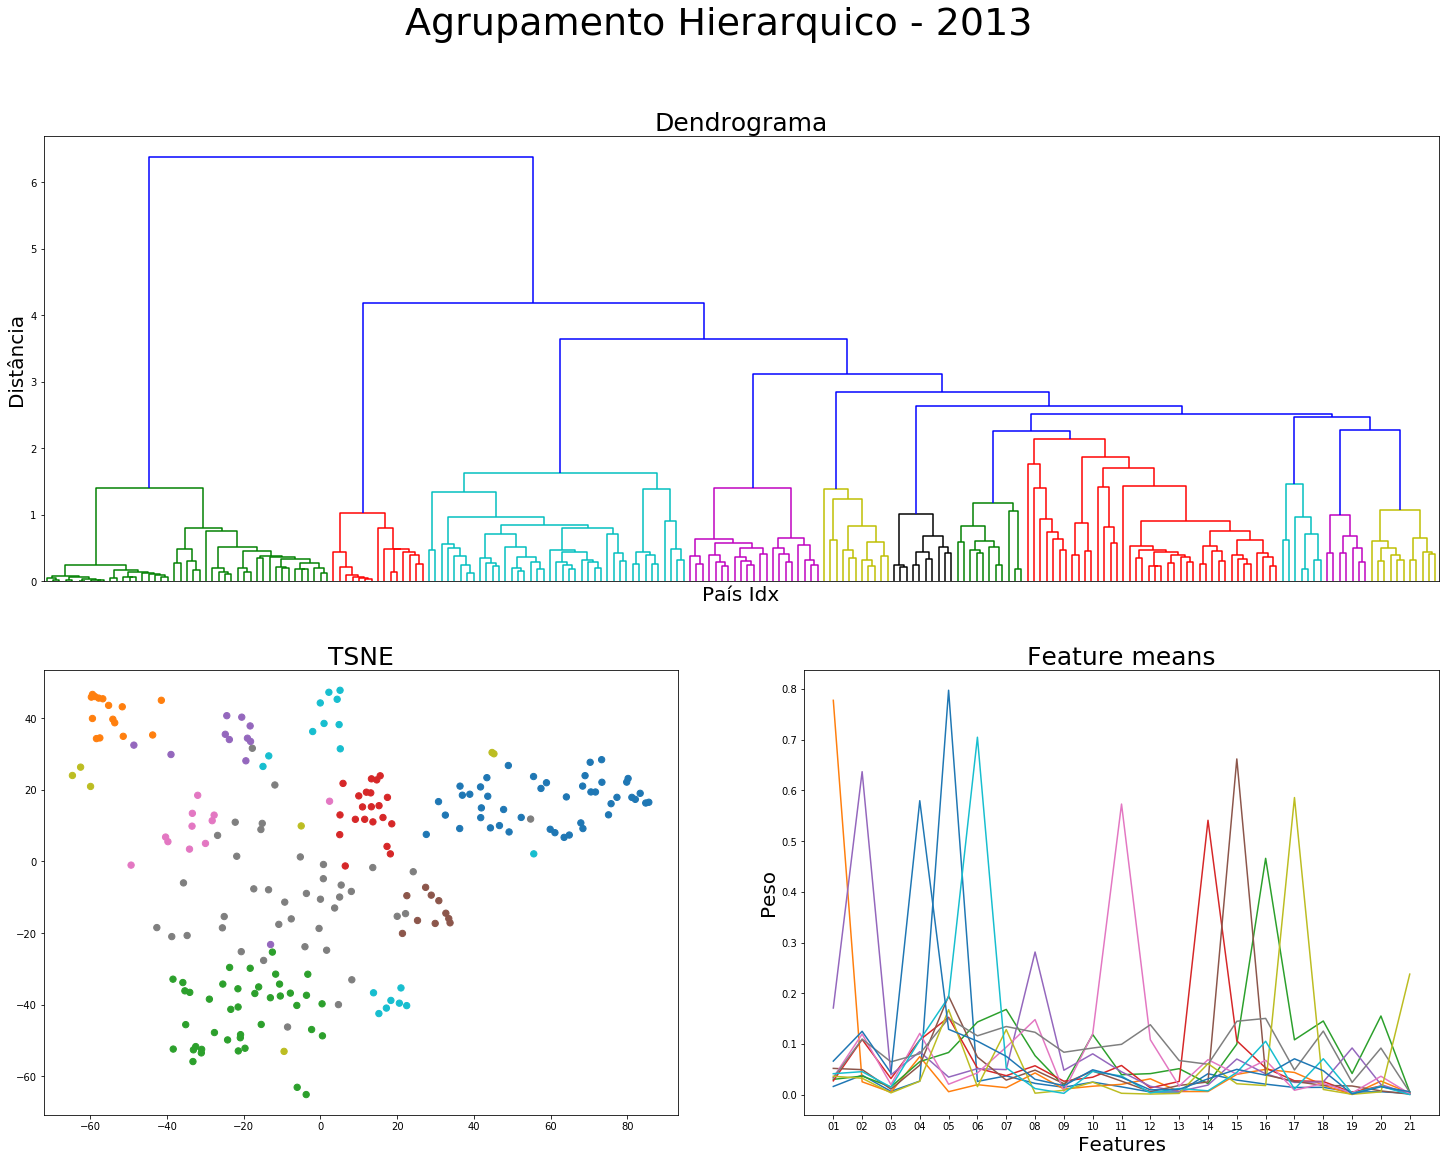

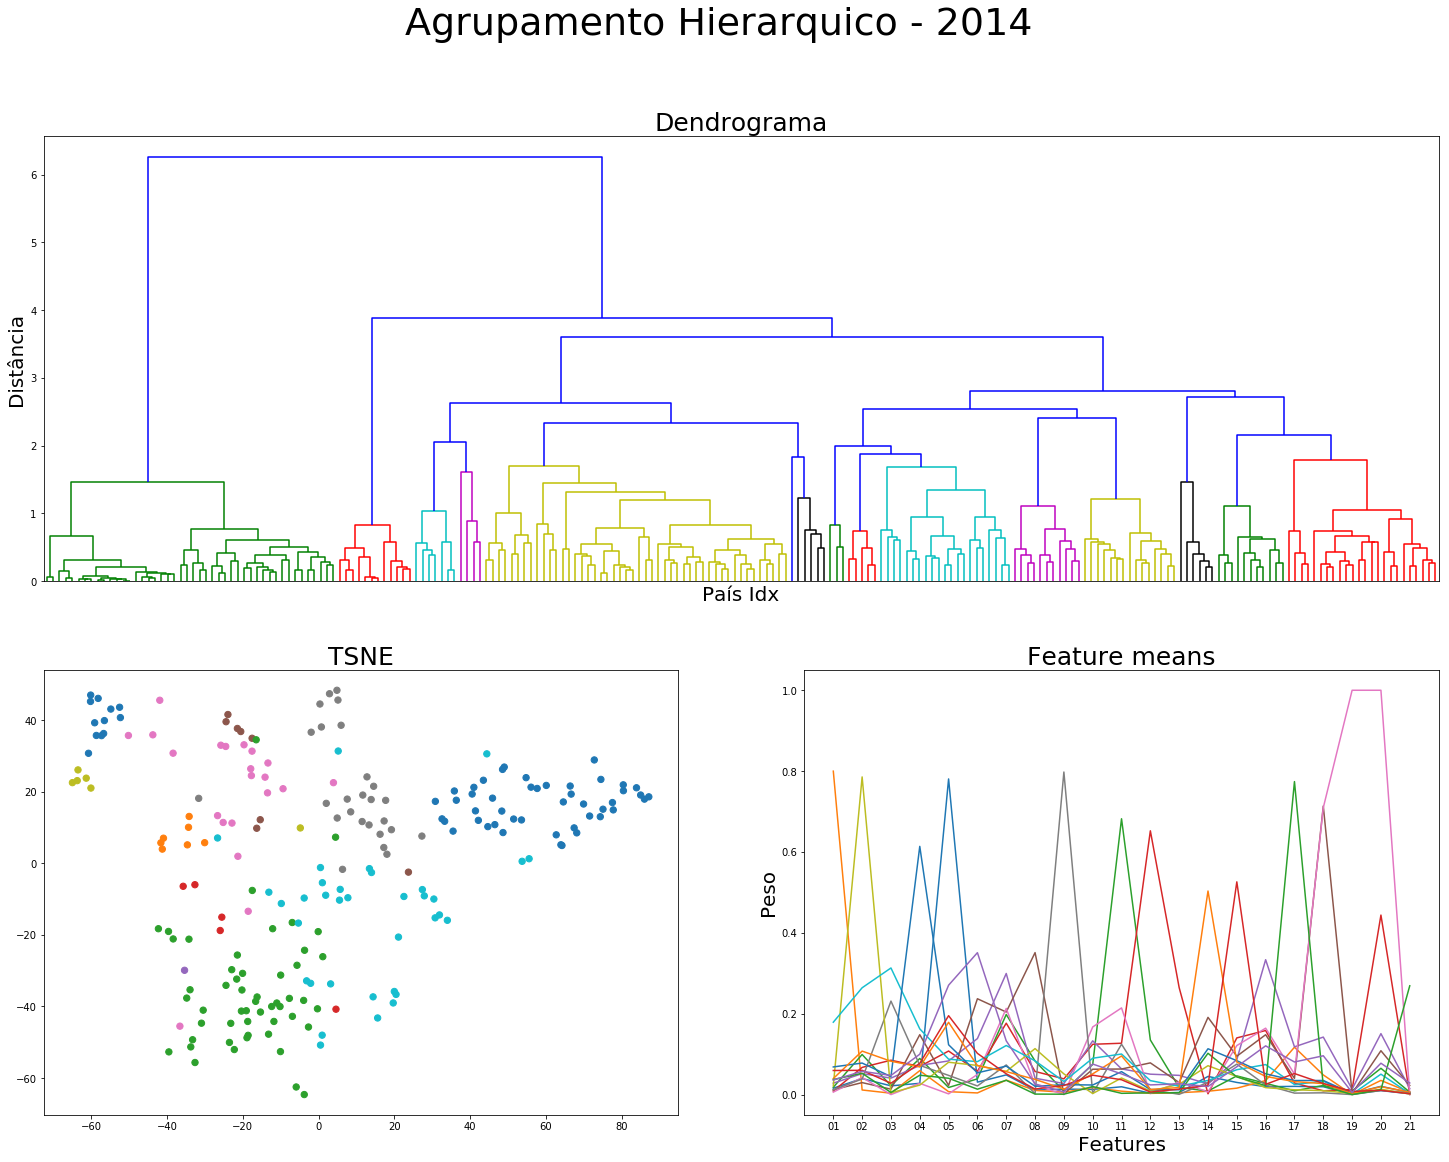

In [14]:
num_h = list(results.idxmax())
scores_h, cluster = hierarchical_clustering(df_hs07['export_rca'], exp_mapping_hs07, num_h, True, 'exp')

## K-means

In [16]:
# Testando diferentes números de clusters para Exportação
years = df_hs07['export_rca'].index.get_level_values(level='year').unique()
results = pd.DataFrame(columns=years)
for k in range(2,20):
    s, _ = k_means(df_hs07['export_rca'], exp_mapping_hs07, k, False, 'exp')
    results = results.append(pd.Series(s, index=years, name=k))

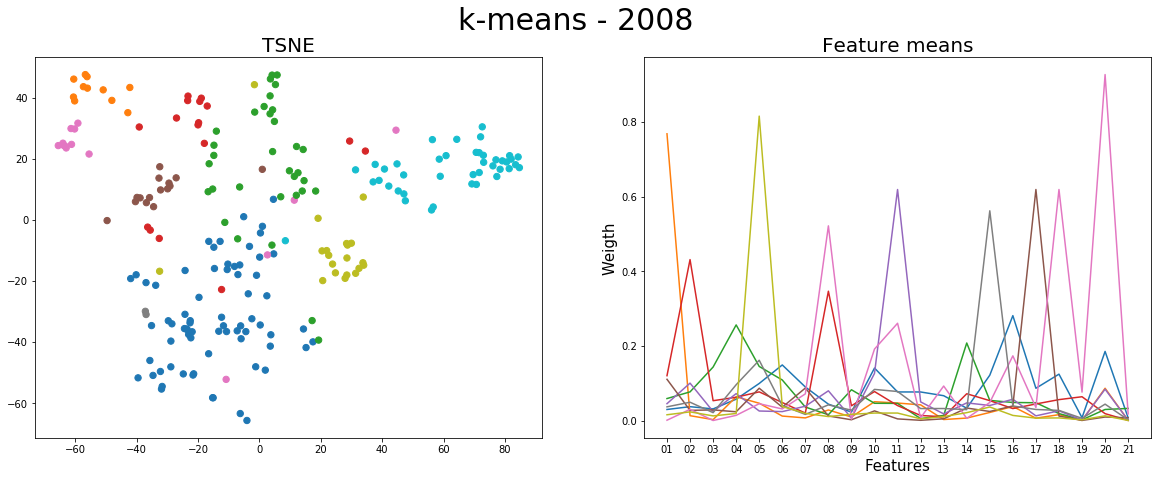

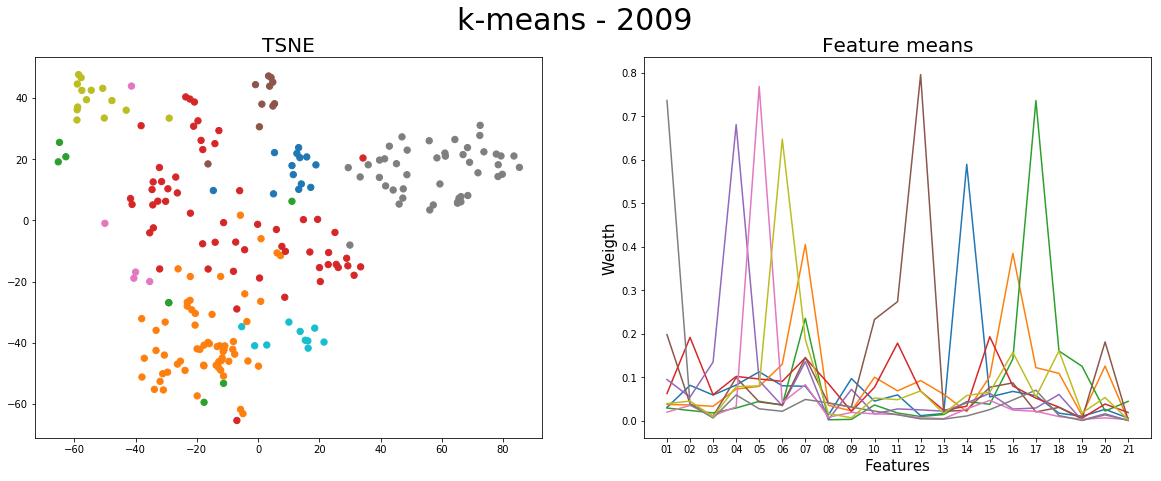

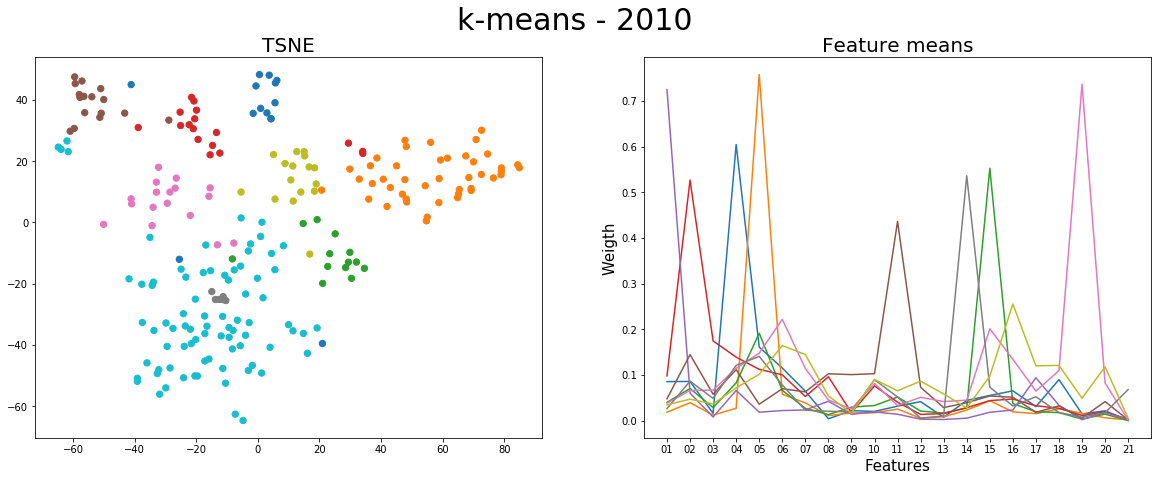

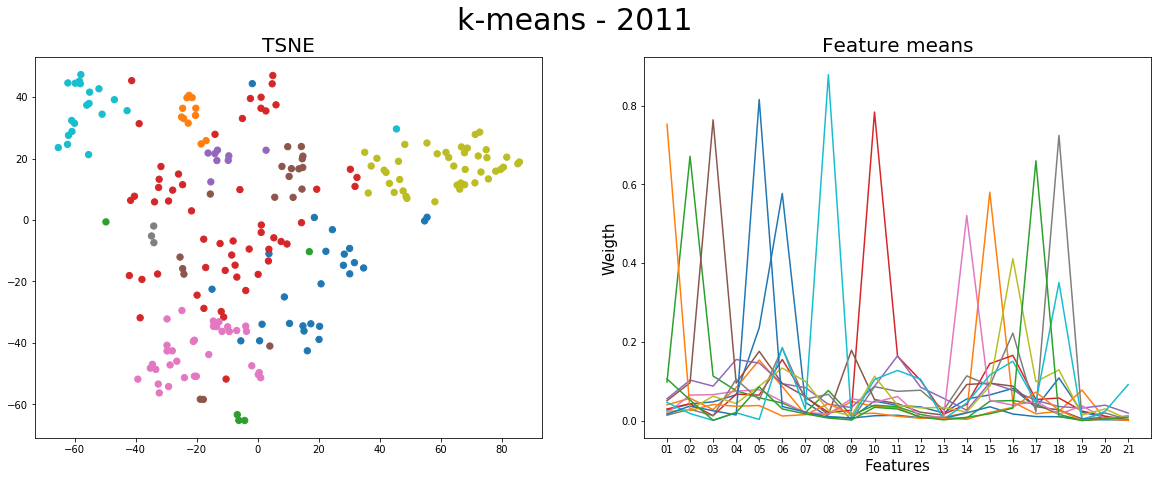

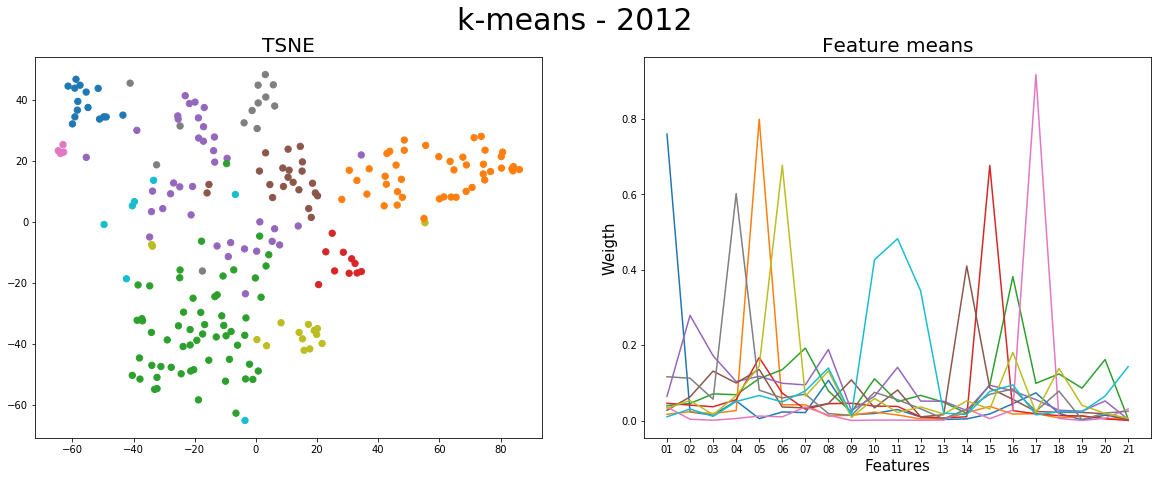

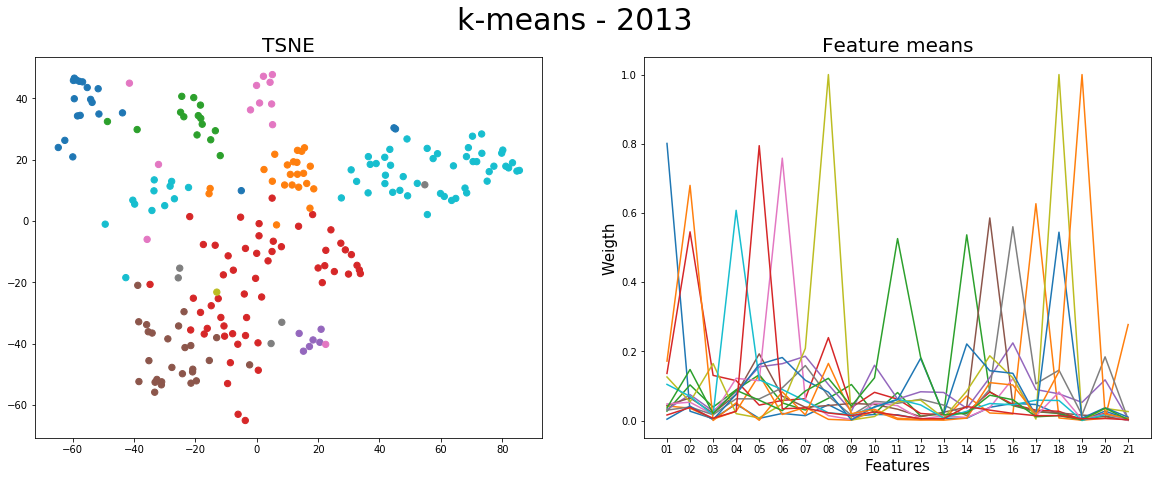

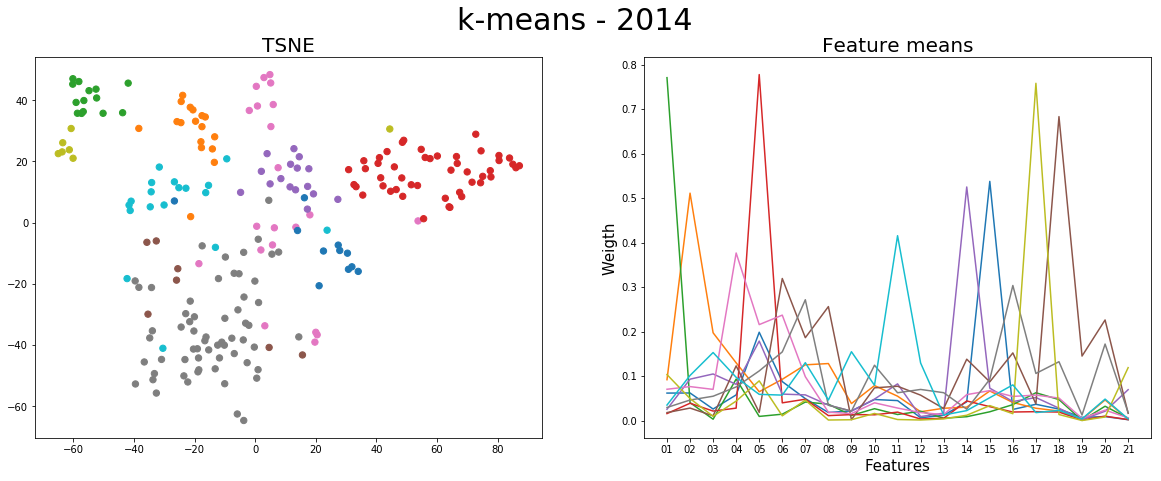

In [20]:
num_k = list(results.idxmax())
scores_k, cluster = k_means(df_hs07['export_rca'], exp_mapping_hs07, num_k, True, 'exp')

### Comparação

In [24]:
index = [['Hierárquico','Hierárquico', 'K-means', 'K-means'], ['Silhueta', 'num_clusters','Silhueta', 'num_clusters']]
r = pd.DataFrame([scores_h, num_h, scores_k, num_k], columns=list(range(2008,2015)), index=index)
r.T

Hierárquico                K-means             
        Silhueta num_clusters  Silhueta num_clusters
2008    0.312835         15.0  0.290129          9.0
2009    0.278655         16.0  0.280519          9.0
2010    0.233286         10.0  0.267113          9.0
2011    0.315076         17.0  0.296935         13.0
2012    0.293350         14.0  0.290140         10.0
2013    0.309512         11.0  0.308026         14.0
2014    0.271725         15.0  0.286965         10.0